# Transfer Learning for Face Classification (Gender, Race, and Age)

In this notebook, we will use this [dataset](https://susanqq.github.io/UTKFace/) which contains 20000 photos of people from 0 to 116 years old (the version in which all pictures are of the same size with faces centered). Classification targets are gender (male/female), race (white/black/asian/indian/other), and age. Transfer learning and fine-tuning will be used in the classification process.

![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

## Base model

We will use a model that is pretrained on the [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) dataset containing 3.3 million images of 9000 different people. The choice of the model is justified by that the training dataset contains a large enough amount of records, accounts for the variation of pose, age, and ethnicity, and minimizes the noise, thus making classification faster and more accurate.

## Loading the pretrained model

The network that we will be using for transfer learning is available in open source: https://github.com/rcmalli/keras-vggface

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-z9buej2x
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-z9buej2x
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=e236698029fab645cc22e69407da1205de4074ed9a6c602807f78d2aa6b85f1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0w3gpzdg/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Let us download the preliminarily saved model from [here](https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO)

In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:00, 368MB/s]


'resnet50face.h5'

In [ ]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

In [ ]:
vggface_model.summary() # the last layer classifies into 8631 labels

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Check that model prediction is valid using the following image:

In [ ]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2020-12-15 03:06:22--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.26.7.169, 172.67.74.175, 104.26.6.169, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.26.7.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41064 (40K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  40.10K  --.-KB/s    in 0s      

2020-12-15 03:06:22 (132 MB/s) - ‘brad_pitt.jpg’ saved [41064/41064]



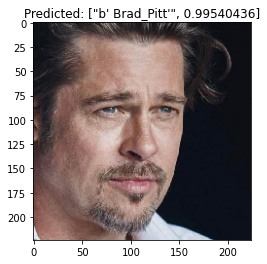

In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # the model works with pictures of size 224x224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)

preds = vggface_model.predict(x)
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}")
plt.imshow(img)

## Loading the data

In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:00, 245MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 76.7MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # each file name contains the age and indices of gender and race separated by underscores

23708
['57_0_0_20170111201356375.jpg.chip.jpg', '24_1_3_20170119171105800.jpg.chip.jpg', '50_0_1_20170113182107886.jpg.chip.jpg']


In [ ]:
# shaping a dataframe with file paths and classification classes
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # normalize the age from 0 to 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,29_1_0_20170103163726008.jpg.chip.jpg,0.250000,0,1
1,52_0_1_20170117173744776.jpg.chip.jpg,0.448276,1,0
2,34_0_1_20170113155438945.jpg.chip.jpg,0.293103,1,0
3,1_1_2_20161219220348151.jpg.chip.jpg,0.008621,2,1
4,36_1_1_20170117171355933.jpg.chip.jpg,0.310345,1,1


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Check that the class labels are valid:

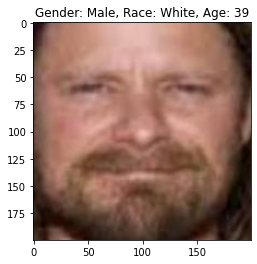

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Let us look at their distribution:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


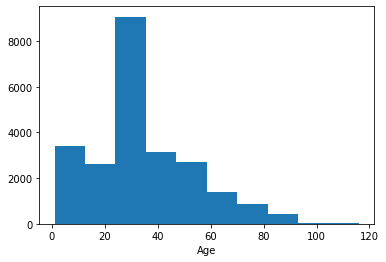

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Creating a data generator for the gender prediction model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- tensor of size (1, H, W, 3)
    
    return: image with preprocess_input(..., version=2) applied
    """
    
    preprocessed = utils.preprocess_input(image_, version=2)

    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(dataframe=df_train,
                                                x_col="img_name",
                                                y_col="gender",
                                                class_mode="binary",
                                                directory=str(data_folder),
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True)

val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                              x_col="img_name",
                                              y_col="gender",
                                              class_mode="binary",
                                              directory=str(data_folder),
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [ ]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Let us show a sample image and its label:

In [ ]:
def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912

    return x_temp

Female


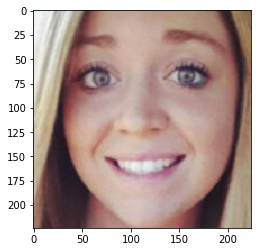

In [ ]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) image after preprocessing
    contains negative values and is not displayed correctly in matplotlib
    
    return: validly displayed image of type np.uint8
    """
    
    image = np.copy(vggface_image)

    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912

    image = image[..., ::-1]

    image = image.astype(np.uint8)

    return image

plt.imshow(deprocess_image(sample_images[10]))
print(gender_mapping[int(sample_labels[10])])

## Training the gender prediction model

In [ ]:
# first, remove the last classifier layer in vggface_model
# now base_model outputs 2048-dimensional feature vector

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
path = Path("/My Drive/model_gender")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "checkpoint_best.h5"  
cpt_path = str(path / cpt_filename)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# checking the number of layers in the base model
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [ ]:
fine_tune_at = 150
# freeze all layers before the fine-tuning threshold
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model = tf.keras.Sequential([

    base_model,

    tf.keras.layers.Dense(512, activation="relu"),

    tf.keras.layers.Dense(256 ,activation='relu'),

    tf.keras.layers.Dense(32 ,activation='relu'),

    tf.keras.layers.Dense(1,activation='sigmoid')

])


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 24,749,825
Trainable params: 10,117,953
Non-trainable params: 14,631,872
_________________________________________________________________


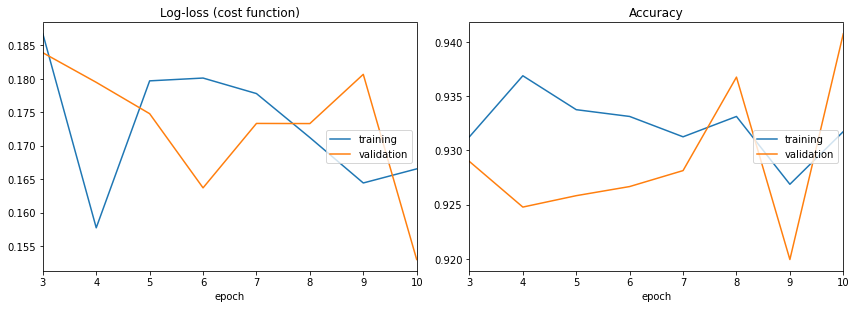

Log-loss (cost function):
training   (min:    0.158, max:    0.359, cur:    0.167)
validation (min:    0.153, max:    0.250, cur:    0.153)

Accuracy:
training   (min:    0.829, max:    0.937, cur:    0.932)
validation (min:    0.919, max:    0.941, cur:    0.941)

Epoch 00010: val_acc improved from 0.93675 to 0.94074, saving model to /My Drive/model_gender/checkpoint_best.h5
25/25 [==============================] - 27s 1s/step - loss: 0.1609 - acc: 0.9317 - val_loss: 0.1530 - val_acc: 0.9407


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint],
    steps_per_epoch=25)

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

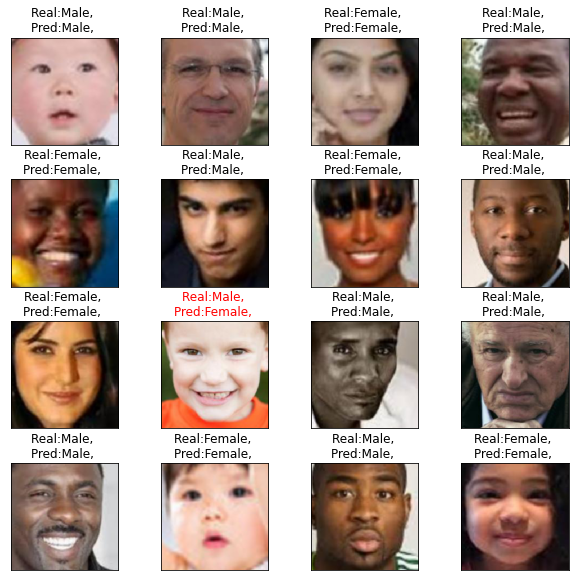

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

## Training the race prediction model

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(dataframe=df_train,
                                                x_col="img_name",
                                                y_col="race",
                                                class_mode="sparse",
                                                directory=str(data_folder),
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True)

val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                              x_col="img_name",
                                              y_col="race",
                                              class_mode="sparse",
                                              directory=str(data_folder),
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
path = Path("/My Drive/model_race")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "checkpoint_best.h5"  
cpt_path = str(path / cpt_filename)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [ ]:
fine_tune_at = 125
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model = tf.keras.Sequential([

    base_model,

    tf.keras.layers.Dense(512, activation="relu"),

    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')

])


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23561152  
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_22 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 165       
Total params: 24,749,957
Trainable params: 17,535,429
Non-trainable params: 7,214,528
_________________________________________________________________


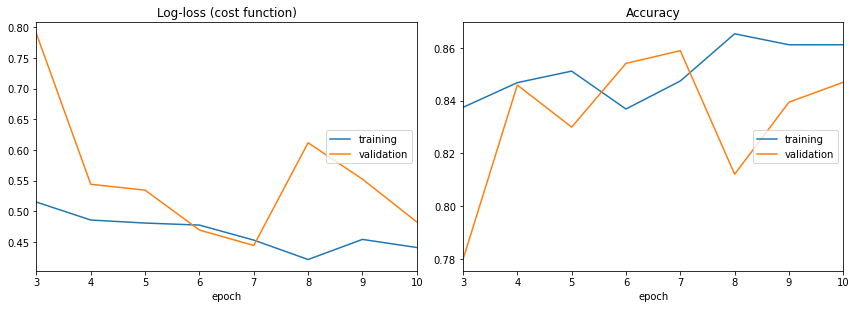

Log-loss (cost function):
training   (min:    0.421, max:    0.896, cur:    0.441)
validation (min:    0.444, max:    2.140, cur:    0.483)

Accuracy:
training   (min:    0.744, max:    0.865, cur:    0.861)
validation (min:    0.633, max:    0.859, cur:    0.847)

Epoch 00010: val_acc did not improve from 0.85900
25/25 [==============================] - 14s 573ms/step - loss: 0.4408 - acc: 0.8612 - val_loss: 0.4826 - val_acc: 0.8470


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint],
    steps_per_epoch=25)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

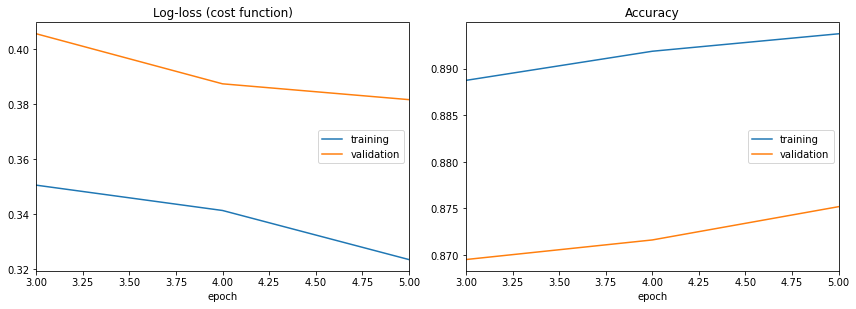

Log-loss (cost function):
training   (min:    0.324, max:    0.358, cur:    0.324)
validation (min:    0.382, max:    0.440, cur:    0.382)

Accuracy:
training   (min:    0.879, max:    0.894, cur:    0.894)
validation (min:    0.857, max:    0.875, cur:    0.875)

Epoch 00005: val_acc improved from 0.87161 to 0.87518, saving model to /My Drive/model_race/checkpoint_best.h5
25/25 [==============================] - 15s 608ms/step - loss: 0.3236 - acc: 0.8938 - val_loss: 0.3816 - val_acc: 0.8752


In [ ]:
EPOCHS = 5
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint],
    steps_per_epoch=25)

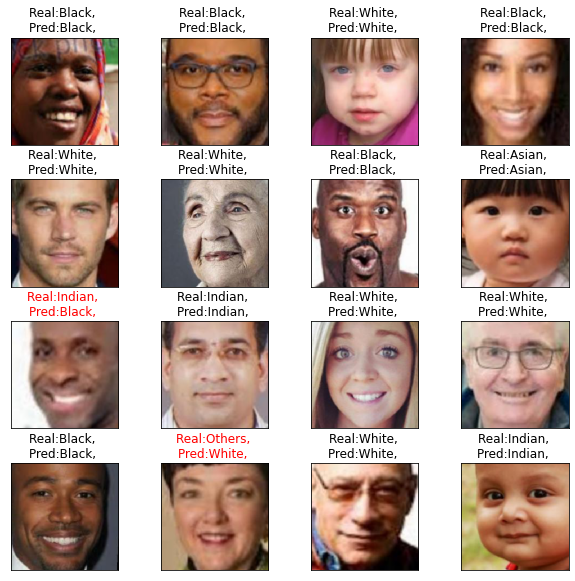

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Multitask learning

We will adjust the same model to predict all of the following: gender (1 output - probability), race (5 outputs - probabilities), and age (1 output - number).

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

Количество слоев в базовой модели:  175
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2048)         23561152    input_6[0][0]                    
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 512)          1049088     model_2[5][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 256)          131328      dense_30[0][0]                   
____________________________________________________

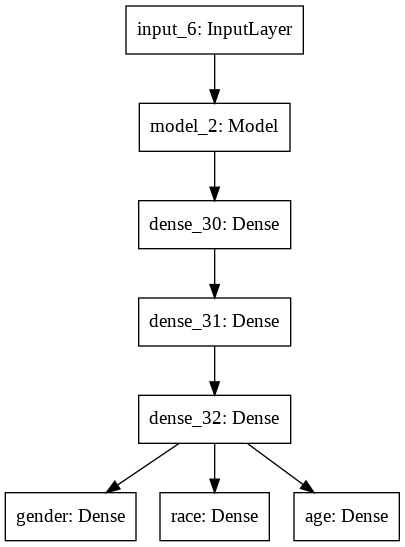

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model


input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

fine_tune_at = 125
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


l1_output = base_model(input_layer)
l2_output = tf.keras.layers.Dense(512, activation="relu")(l1_output)
l3_output = tf.keras.layers.Dense(256, activation="relu")(l2_output)
l4_output = tf.keras.layers.Dense(32, activation="relu")(l3_output)


gender_output = tf.keras.layers.Dense(1, name="gender", activation="sigmoid")(l4_output)
race_output = tf.keras.layers.Dense(5, name="race", activation="softmax")(l4_output)
age_output = tf.keras.layers.Dense(1, name="age", activation="sigmoid")(l4_output)

model = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

model.summary()
plot_model(model)

In [ ]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [ ]:
BATCH_SIZE = 64

train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"],
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    A helper function that updates image generators so they can be
    used for Multitask learning
    image_gen.flow_from_dataframe returns the following batch on each iteration:
    ((N, H, W, 3), (N, 3)) -- N images and N label triples (for three tasks)
    model.fit(..) expects a generator as input in the following format:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])
    
    This function is necessary for adjusting the format.
    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


Now on to training the model:

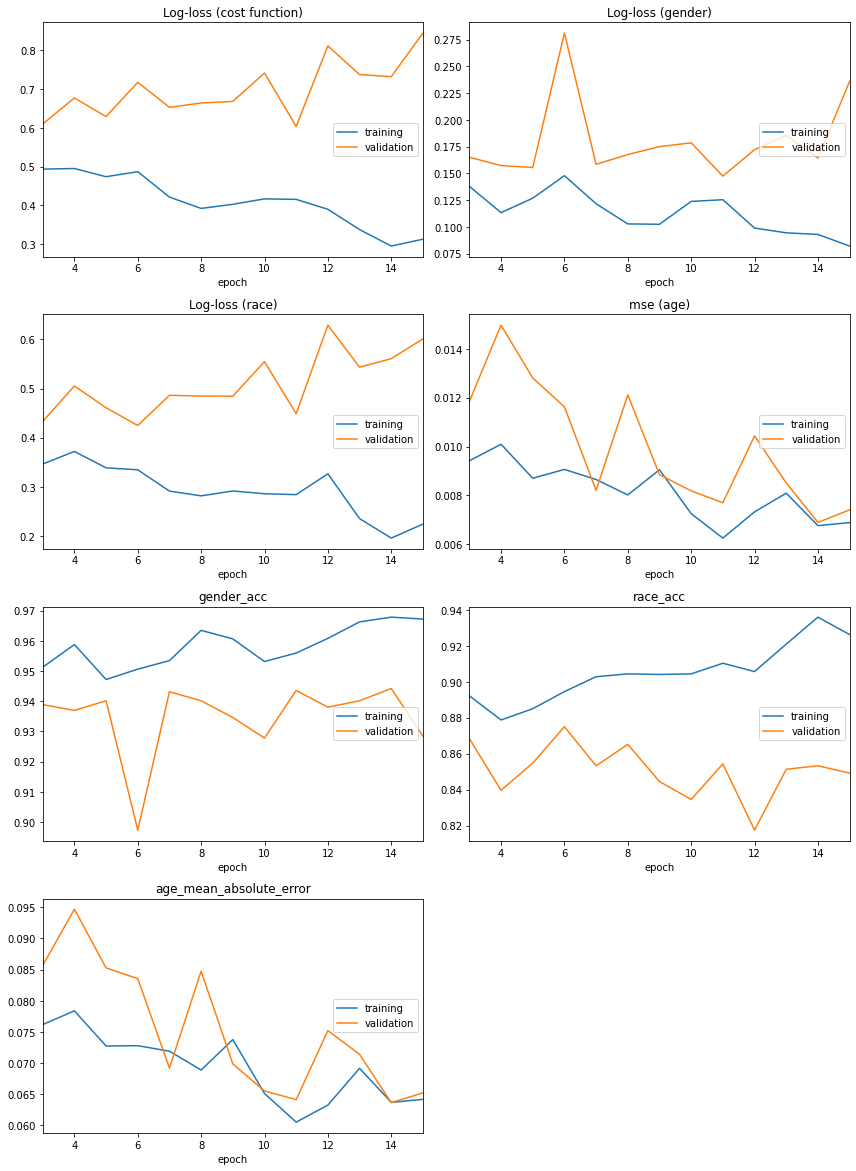

Log-loss (cost function):
training   (min:    0.295, max:    0.686, cur:    0.313)
validation (min:    0.604, max:    0.845, cur:    0.845)

Log-loss (gender):
training   (min:    0.082, max:    0.172, cur:    0.082)
validation (min:    0.147, max:    0.305, cur:    0.236)

Log-loss (race):
training   (min:    0.196, max:    0.484, cur:    0.224)
validation (min:    0.425, max:    0.629, cur:    0.601)

mse (age):
training   (min:    0.006, max:    0.029, cur:    0.007)
validation (min:    0.007, max:    0.017, cur:    0.007)

gender_acc:
training   (min:    0.929, max:    0.968, cur:    0.967)
validation (min:    0.890, max:    0.944, cur:    0.928)

race_acc:
training   (min:    0.849, max:    0.936, cur:    0.926)
validation (min:    0.817, max:    0.875, cur:    0.849)

age_mean_absolute_error:
training   (min:    0.061, max:    0.131, cur:    0.064)
validation (min:    0.064, max:    0.100, cur:    0.065)

Epoch 00015: val_age_mean_absolute_error did not improve from 0.06364
50/50

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [ ]:
model_multitask = load_model("model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
74/74 [==============================] - 10s 141ms/step - loss: 0.8441 - gender_loss: 0.2340 - race_loss: 0.6026 - age_loss: 0.0074 - gender_acc: 0.9288 - race_acc: 0.8499 - age_mean_absolute_error: 0.0651
Well done!


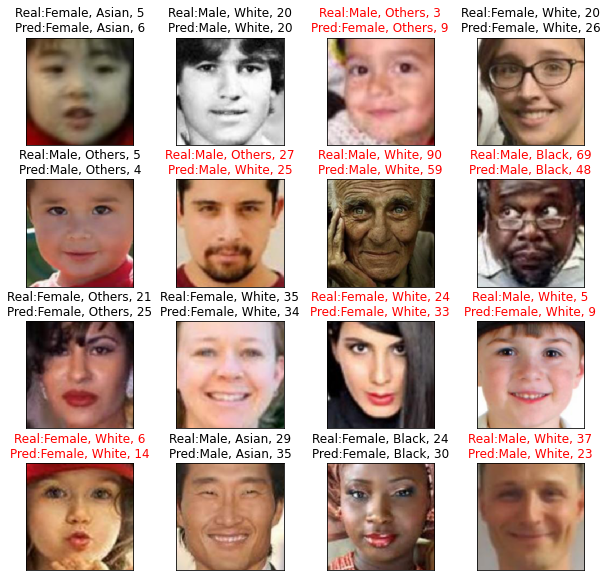

In [ ]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

## Check the result

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: /content/me.jpg
2.34MB [00:00, 199MB/s]


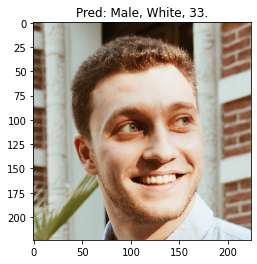

In [ ]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'sample.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("sample.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# the male and race were predicted correctly, the age was a slight underestimation